In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [2]:
def salarisfeh(feh,al):
    '''
    Calculate the Salaris corrected from Salaris et al. 1993
    
    Inputs:
    ------
        feh: [Fe/H]
        al: [alpha/Fe]
    
    Output:
    ------
        salfeh: Salaris Corrected [Fe/H]
    '''
    
    salfeh = feh+np.log10(0.638*(10**(al))+0.362)
    return salfeh

leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# APOKASC

In [3]:
# APOKASC
from astropy.io import ascii
kasc = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

### xmatch DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, kasc_ind, dr17_ind = np.intersect1d(kasc['2MASS_ID'],dr17['APOGEE_ID'], return_indices=True)

kascdr17 = dr17[dr17_ind]
kasc = kasc[kasc_ind]

### xmatch kasc2 and kasc3
_, kasc3_ind, kasc_ind = np.intersect1d(kasc3['2MASSID'],kasc['2MASS_ID'], return_indices=True)

kasc = kasc[kasc_ind]
kasc3dr17 = kascdr17[kasc_ind]
kasc3 = kasc3[kasc3_ind]

ageevs = np.where((kasc3['IntAge']>-10.)&(kasc['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kasc3dr17['FE_H']<=0.0)&
                  (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

kasc3dr17 = kasc3dr17[ageevs]
kasc3 = kasc3[ageevs]

# OCCAM

In [63]:
# PM_PROB > 0.01 && RV_PROB > 0.01 && FEH_PROB > 0.01.

# occluster = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/occam_cluster-DR16.fits.gz')
ocmember = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/occam_member-DR16.fits.gz') 

ocmember = ocmember[np.where((ocmember['PM_PROB']>0.01)&(ocmember['RV_PROB']>0.01)&(ocmember['FEH_PROB']>0.01))]

_, kasc36791, occam_ind = np.intersect1d(kasc3dr17['APOGEE_ID'],
                                        ocmember['APOGEE_ID'][np.where(ocmember['CLUSTER']=='NGC 6791')],
                                        return_indices=True)

ngc6791dr17 = kasc3dr17[kasc36791]
ngc6791 = kasc3[kasc36791]

_, kasc_occam, occam_kasc = np.intersect1d(kasc3dr17['APOGEE_ID'],ocmember['APOGEE_ID'],return_indices=True)
occamkasc17 = kasc3dr17[kasc_occam]
occamkasc3 = kasc3[kasc_occam]

In [64]:
ocmember.columns

ColDefs(
    name = 'CLUSTER'; format = '13A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'LOCATION_ID'; format = 'K'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'VHELIO_AVG'; format = 'D'
    name = 'VSCATTER'; format = 'D'
    name = 'FE_H'; format = 'D'
    name = 'FE_H_ERR'; format = 'D'
    name = 'PMRA'; format = 'D'
    name = 'PMRA_ERR'; format = 'D'
    name = 'PMDEC'; format = 'D'
    name = 'PMDEC_ERR'; format = 'D'
    name = 'RV_PROB'; format = 'D'
    name = 'FEH_PROB'; format = 'D'
    name = 'PM_PROB'; format = 'D'
    name = 'CG_PROB'; format = 'D'
)

Likely members are PM_PROB > 0.01 && RV_PROB > 0.01 && FEH_PROB > 0.01. Unfortunately we didn't include log(g) in that file because it isn't directly related to our membership criteria, but you could match to the allstar file pretty painlessly. 

In [65]:
afe = ngc6791dr17['ALPHA_M']+ngc6791dr17['M_H']-ngc6791dr17['FE_H']
afeok = ngc6791dr17['ALPHA_M']+ngc6791dr17['M_H']-ngc6791dr17['FE_H']

# Ages

In [66]:
ages = Table(fits.getdata('APOKASC_rgb_SalarisCNAlpha.fits'))[kasc36791]
agesok = Table(fits.getdata('APOKASC_rgb_SalarisCNAlpha.fits'))[kasc_occam]

In [67]:
ngc6791.columns

<TableColumns names=('KICID','Mass','Logg','Fe/H','Al/Fe','Teff','C/N','M_err','Logg_err','Fe/H_err','Al/Fe_err','Teff_err','2MASSID','IntTeff','IntML','IntAge','IntC12','IntC13','IntN14','IntXsurf')>

In [68]:
def upturn10Gyr(age):
    '''
    Boundary for 10 Gyr upturn in Aetas and APOKASC plot 
    
    Input:
    -----
        age: age in Gyr
        
    Output:
    ------
        ups: value on boundary 
    '''
    ups = np.ones(np.size(age))
    for i in range(np.size(age)):
        if age[i] <= 11:
            up = 11

        else:
            up = age[i]
            
        ups[i] = up

    return ups

def oldapokasc(age):
    '''
    Boundary for old stars in APOKASC given young age by Aetas
    
    Input:
    -----
        age: age in Gyr
    
    Output:
    ------
        olds: value on boundary
    '''
    olds = np.ones(np.size(age))
    for i in range(np.size(age)):
        olds[i] = age[i] - 4
        
    return olds

# NGC 6791

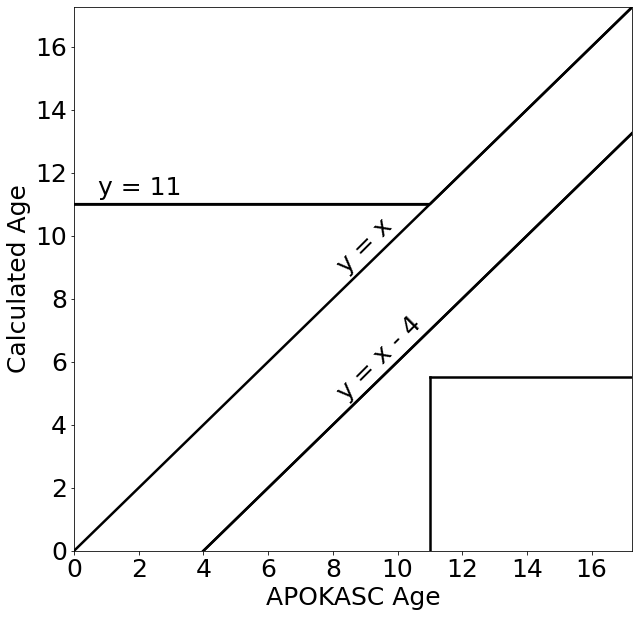

In [74]:
#### Scatterplot Version ####
plt.figure(figsize=[10,10])

plt.scatter(ngc6791['IntAge'],ages['AGE'])#,c=afe,cmap='jet')
# plt.colorbar()

plt.plot(np.arange(0,18,0.25),upturn10Gyr(np.arange(0,18,0.25)),c='k',lw=2.5)
plt.plot(np.arange(0,18,0.25),oldapokasc(np.arange(0,18,0.25)),c='k',lw=2.5)

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xlabel(r'APOKASC Age')
plt.ylabel(r'Calculated Age')


plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))
plt.show()

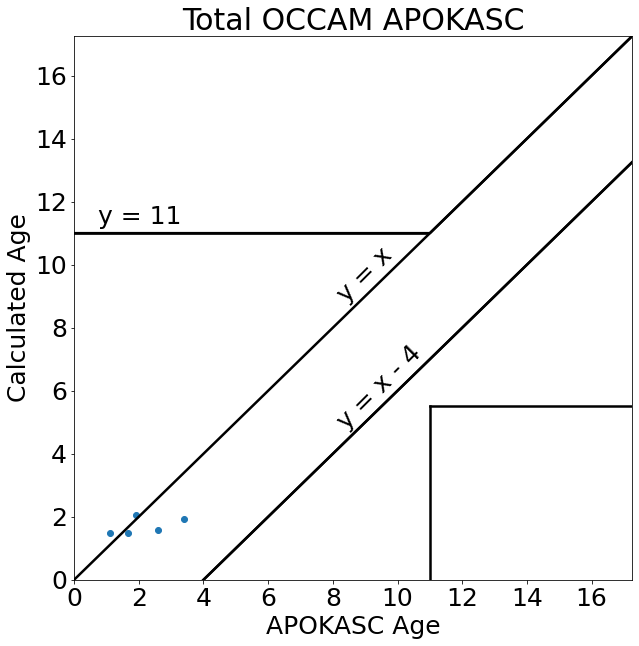

In [70]:
plt.figure(figsize=[10,10])

plt.scatter(occamkasc3['IntAge'],agesok['AGE'],cmap='jet')

plt.plot(np.arange(0,18,0.25),upturn10Gyr(np.arange(0,18,0.25)),c='k',lw=2.5)
plt.plot(np.arange(0,18,0.25),oldapokasc(np.arange(0,18,0.25)),c='k',lw=2.5)

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.title(r'Total OCCAM APOKASC')
plt.xlabel(r'APOKASC Age')
plt.ylabel(r'Calculated Age')

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))
plt.show()

In [71]:
print(len(occamkasc3))
print(len(agesok))
print(len(afeok))

5
5
0
